In [2]:
import logging 
from collections import Counter, namedtuple
import random 
from math import exp,ceil
import matplotlib.pyplot as plt 

In [3]:
def problem(N, seed=None):
    """Creates an instance of the problem"""

    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

$\alpha_i$ = the set of  columns that cover row $i$ , $i$  $\in$  $I$ 

In [4]:
def generate_alpha(N, beta , costs):
    alpha = dict()
    a = namedtuple("a", ["sublists","subcosts"])
    for i in range(N): 
        sublist = list()
        subcosts = list()
        for index , sub in enumerate(beta): 
            if i in sub: 
                sublist.append(index)
                subcosts.append(costs[index])
        alpha[i] = a(sublist,subcosts)
    return alpha 

$w_i$ = the number of columns that cover row $i$

In [5]:
def generate_w(N, beta,solution):
    w = list()
    
    for i in range(N): 
        n = 0

        for index , sub in enumerate(solution): 
            if (sub == 1) and (i in beta[index]) : 
                n +=1

        w.append(n)
    return w 

In [6]:
def update_w(i,w,beta):
    for j in beta[i]: 
        w[j]-=1

    return w    

$U$ = the set of uncovered rows

In [7]:
def generate_U(gamma):
    U = list()
    for index,ele in enumerate(gamma): 
        if ele == 0: 
            U.append(index)
    return U


$I$ =  set of numbers to cover , we will refer to them as rows, 

$J$ =  total subsets used to cover $I$, we will refer to them as columns,

In [8]:
N =  500 # choose between 5,10,20,100,500,1000
beta = problem(N, seed= 42)
beta = sorted(beta , key = lambda i : len(i) )
costs = list( len(s) for s  in beta)
binary = [0 for x in range(len(beta))]
alpha = generate_alpha(N,beta,costs)
dictionary = {5:[],10:[],20:[],100:{"generations":1500,"mutation bits":50,"tournament":10},500:{"generations":1500,"mutation bits":100},1000:[]}

FITNESS , PARENT SELECTION , CROSS-OVER , MUTATION

In [27]:
def fitness(w): 
    
    return sum([ ele for ele in w ])

def parent_selection(population,total ,tournament_size=10):
    
    return min(random.choices(population,[ (total - gene.fitness/total) for gene in population] , k=tournament_size), key=lambda i: i.fitness)

#def cross_over(p1,p2,child): 
#    
#    for i in range(len(binary)): 
#        if p1.genome[i] == p2.genome[i]:
#             child[i] = p1.genome[i]
#        else : 
#            prob = random.random()     
#            if prob < p2.fitness/(p1.fitness +p2.fitness):
#                 child[i] = p1.genome[i]
#            else: 
#                child[i] = p2.genome[i]
#    return child  

def cross_over(p1,p2): 
    decision=random.choice([0,1]) 
    cut = random.randint(0, len(beta)-1)
    if decision :
        return p1.genome[:cut] + p2.genome[cut:]
    else :
        return p2.genome[:cut] + p1.genome[cut:]
    



def mutation(child):
       
        indexes = random.choices(list(range(len(beta))), k =100)

        
        for i in indexes:
            child[i] = 1 - child[i]
        return child

INITIAL POPULATION

In [28]:
Individual = namedtuple("Individual", ["genome", "fitness"])
def generate_population(size):
    population = list()
    ## step (ii) 1- randomly select a subset (column) in alpha  2- add the selected column to S 
    for _ in range(size): 


        solution =  [0 for _ in range(len(beta))]
        for i in range(N): 
            j = random.choice(alpha[i].sublists)
            solution[j] = 1

        S  = [i for i, val in enumerate(solution) if val]
        K = len(S) # K contains the columns index in the solution 
        w = generate_w(N,beta,solution)
        
        ## step (iv) 1-randomly select a column from the generated solution 2- check if the elements in tht column (covered numbers) have been already covered already twice 
        ## objective is remove redundant subsets (columns)
        
        while K != 0: 
            
            j = random.choice(S)
            threshold = len(beta[j])
            rep = 0
            for i in beta[j]:
                if w[i] >=2:
                    rep +=1
            if rep == threshold: 
                solution[j] = 0 
                w = update_w(j,w,beta)
            S.remove(j)
            K -= 1 
        population.append(Individual(solution, fitness(w)))    
    
    return population
            

HEURISTIC FEASABILITY OPERATOR

In [17]:
def turn_feasable(child,beta,N):
    def intersection(lst1, lst2):
        inter = list(set(lst1) & set(lst2))
        if inter !=0: 
            return len(inter)
        else: 
            return 0.000001
    
    w = generate_w(N,beta,child)
    U = generate_U(w)
    ## find the columns that do not exits in the solution , that minimize 
    while len(U)!=0: 
        indexes =  alpha[U[0]].sublists
        j = sorted(indexes , key = lambda i : len(beta[i])/intersection(U,beta[i]))[0]
        child[j] = 1
        U = list(set(U) - set(beta[j]))
    
    S  = [i for i, val in enumerate(child) if val]
    w = generate_w(N,beta,child)
    
    for j in reversed(S):
        
        threshold = len(beta[j])
        
        #rep=sum(list(map(lambda x: 1 if w[x]>=2 else 0,beta[j])))
        rep = 0
        for i in beta[j]:
            if w[i] >=2:
                rep +=1
        if rep == threshold: 
            child[j] = 0 
            w = update_w(j,w,beta)
    
    return child , w


GENETIC ALGORITHM

In [25]:
POPULATION_SIZE = 150
population = generate_population(POPULATION_SIZE)
fitness_log = [(0, i.fitness) for i in population]
NUM_GENERATIONS = 800
OFFSPRING_SIZE = 10
logging.getLogger().setLevel(logging.INFO)
for g in range(NUM_GENERATIONS):
    offspring = list()
    for i in range(OFFSPRING_SIZE):
        
        tot_fitness = sum([ gene.fitness for gene in population])
        p1 = parent_selection(population,tot_fitness)
        p2 = parent_selection(population, tot_fitness)
        child = cross_over(p1, p2)
        child = mutation(child)
        child,w = turn_feasable(child,beta,N)
        f = fitness(w)
        fitness_log.append((g + 1, f))
        offspring.append(Individual(child, f))
    population += offspring
    population = sorted(population, key=lambda i: -i.fitness, reverse=True)[:POPULATION_SIZE]
    logging.info(f"GENERATION {g}, FITNESS {population[0].fitness}")

logging.info(f"FINAL SOLUTION , FITNESS {population[0][1]} ")


INFO:root:GENERATION 0, FITNESS 1577
INFO:root:GENERATION 1, FITNESS 1577
INFO:root:GENERATION 2, FITNESS 1577
INFO:root:GENERATION 3, FITNESS 1577
INFO:root:GENERATION 4, FITNESS 1577
INFO:root:GENERATION 5, FITNESS 1577
INFO:root:GENERATION 6, FITNESS 1560
INFO:root:GENERATION 7, FITNESS 1560
INFO:root:GENERATION 8, FITNESS 1560
INFO:root:GENERATION 9, FITNESS 1555
INFO:root:GENERATION 10, FITNESS 1555
INFO:root:GENERATION 11, FITNESS 1555
INFO:root:GENERATION 12, FITNESS 1555
INFO:root:GENERATION 13, FITNESS 1555
INFO:root:GENERATION 14, FITNESS 1555
INFO:root:GENERATION 15, FITNESS 1555
INFO:root:GENERATION 16, FITNESS 1555
INFO:root:GENERATION 17, FITNESS 1555
INFO:root:GENERATION 18, FITNESS 1555
INFO:root:GENERATION 19, FITNESS 1555
INFO:root:GENERATION 20, FITNESS 1555
INFO:root:GENERATION 21, FITNESS 1555
INFO:root:GENERATION 22, FITNESS 1555
INFO:root:GENERATION 23, FITNESS 1555
INFO:root:GENERATION 24, FITNESS 1555
INFO:root:GENERATION 25, FITNESS 1545
INFO:root:GENERATION 2

1398


In [21]:
print(population[0][1])
cost  =    sum([ len(beta[index]) for  index,val in enumerate(population[0].genome) if val==1 ])
print(cost)

1387
1387


Text(0, 0.5, 'fitness')

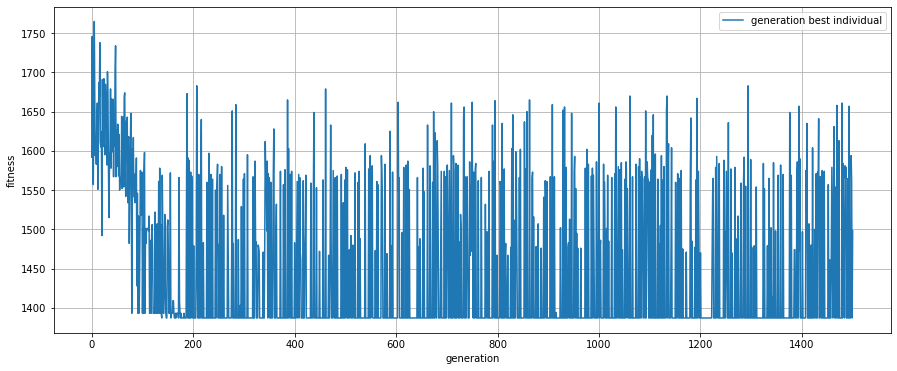

In [22]:

gen_best = [min(f[1] for f in fitness_log if f[0] == x) for x in range(NUM_GENERATIONS+1)]

plt.figure(figsize=(15, 6))
plt.plot([x for x, _ in enumerate(gen_best)], [y for _, y in enumerate(gen_best)], label= "generation best individual")
plt.legend()
plt.grid()
plt.xlabel("generation")
plt.ylabel("fitness")
